In [50]:
import zarr
import pandas as pd
import numpy as np
from datetime import datetime

In [51]:
path = "C:/data_repository/MSFT.zarr"

In [52]:
def compute_vwap(ds):
    return np.sum(ds.price * ds.vol) / np.sum(ds.vol)

In [53]:
def volumeBar(group_data, num_time_bars, df_, total_ticks):
    #reset index of data to calculate 'grpId'
    df_ = df_.reset_index()
    
    #volume total cumsum 
    data_cm_vol = df_.assign(
        cmVol=df_['vol'].cumsum()
    ) 
                
    #total volume 
    total_vol = data_cm_vol.cmVol.values[-1] 
                
    #volume per each bar
    vol_per_bar = total_vol / num_time_bars
    
    #round it to the nearest thousand
    vol_per_bar = round(
        vol_per_bar, -2
    ) * 1e1
    
    #total vol per group-bar ID
    df_["grpId"] = data_cm_vol.cmVol // vol_per_bar 
    
    #group by grpId to categorize density by volume
    data_vol_grp = df_.groupby('grpId')
                
    #get first datetime to construct datafrem
    datetimes_ = data_vol_grp.first()['index']
    
    #vwap over each vol bar group ID
    data_vol_vwap = data_vol_grp.apply(
        compute_vwap
    )
                    
    #construct final dataframe
    result_dataset = pd.concat(
        [
            datetimes_, data_vol_vwap
        ], 
        axis=1
    )
    
    #renaming columns
    result_dataset.columns = [
        "datetime", "price"
    ]
    
    result_dataset = result_dataset.reset_index()
    
    return result_dataset

In [54]:
def openModifiedZarr(path, date_, freq = 1, time='Min'):
    
    """
    """
    
    zarrds= zarr.open_group(path)
    
    infoArrays_ = [
        (
            zarrds.timestamp[idx], 
            zarrds.value[idx], 
            zarrds.vol[idx] 
        ) 
        for idx, date_element in enumerate(
            zarrds.date
        ) if date_element in date_
    ]
    
    infoArrays = [
        (
            tupleArrays[0][tupleArrays[0]!=0], 
            tupleArrays[1][tupleArrays[1]!=0],
            tupleArrays[2][tupleArrays[2]!=0]
        ) 
        for tupleArrays in infoArrays_
    ]
    
    timeArrays = [
        datetime.fromtimestamp(t) 
        for t in infoArrays[0][0]/10**3
    ]
    
    priceArrays, volArrays = infoArrays[0][1], infoArrays[0][2]
    
    #tick price/vol data
    df_ = pd.DataFrame(
        {
            "price":priceArrays, 
            "vol":volArrays,
        }, 
        
        index=timeArrays
    )
    
    group_data = df_.resample(
        '{}{}'.format(freq, time)
    )
    
    num_time_bars = group_data.ngroups
    
    total_ticks = priceArrays.shape[0]

    volBar = volumeBar(
        group_data, 
        num_time_bars, 
        df_, 
        total_ticks
    )
    
    return volBar, group_data.first().iloc[:,[0]]

In [55]:
range_days = ["2020-09-01","2020-09-02","2020-09-03","2020-09-04","2020-09-08","2020-09-09","2020-09-10","2020-09-11","2020-09-14","2020-09-15","2020-09-16"]

In [56]:
#NO CONCADENAR, INGRESAR AL __VOLATILITY__ DÍA POR DÍA
data = [openModifiedZarr(path,day) for day in range_days] 

In [57]:
data

[(    grpId                datetime       price
  0     0.0 2020-09-01 09:30:00.002  225.524384
  1     1.0 2020-09-01 09:31:49.913  225.193968
  2     2.0 2020-09-01 09:34:55.413  224.971279
  3     3.0 2020-09-01 09:39:35.231  225.554131
  4     4.0 2020-09-01 09:45:00.612  225.887231
  5     5.0 2020-09-01 09:51:50.359  226.171321
  6     6.0 2020-09-01 09:58:21.317  226.178547
  7     7.0 2020-09-01 10:04:45.591  226.611006
  8     8.0 2020-09-01 10:10:47.631  226.418399
  9     9.0 2020-09-01 10:17:29.586  226.372180
  10   10.0 2020-09-01 10:26:17.146  226.585940
  11   11.0 2020-09-01 10:35:05.779  226.304363
  12   12.0 2020-09-01 10:45:08.681  226.295336
  13   13.0 2020-09-01 10:55:05.476  225.989997
  14   14.0 2020-09-01 11:06:31.873  225.648525
  15   15.0 2020-09-01 11:16:05.287  226.081352
  16   16.0 2020-09-01 11:25:43.231  226.497959
  17   17.0 2020-09-01 11:35:21.630  226.381474
  18   18.0 2020-09-01 11:47:44.931  226.243178
  19   19.0 2020-09-01 12:06:08.594  226

In [58]:
volBars_ = [element[0] for element in data]

In [59]:
volBars_[0]#.grpId.iloc[-1]

,grpId,datetime,price
0,0.0,2020-09-01 09:30:00.002,225.524384
1,1.0,2020-09-01 09:31:49.913,225.193968
2,2.0,2020-09-01 09:34:55.413,224.971279
3,3.0,2020-09-01 09:39:35.231,225.554131
4,4.0,2020-09-01 09:45:00.612,225.887231
5,5.0,2020-09-01 09:51:50.359,226.171321
6,6.0,2020-09-01 09:58:21.317,226.178547
7,7.0,2020-09-01 10:04:45.591,226.611006
8,8.0,2020-09-01 10:10:47.631,226.418399
9,9.0,2020-09-01 10:17:29.586,226.372180


In [60]:
timeBars_ = [element[1] for element in data]

In [61]:
timeBars_

[                        price
 2020-09-01 09:30:00  225.5200
 2020-09-01 09:31:00  225.8000
 2020-09-01 09:32:00  225.3100
 2020-09-01 09:33:00  225.6300
 2020-09-01 09:34:00  224.8100
 ...                       ...
 2020-09-01 15:55:00  226.9100
 2020-09-01 15:56:00  226.7990
 2020-09-01 15:57:00  226.8699
 2020-09-01 15:58:00  226.9450
 2020-09-01 15:59:00  227.0400
 
 [390 rows x 1 columns],
                        price
 2020-09-02 09:30:00  227.760
 2020-09-02 09:31:00  227.860
 2020-09-02 09:32:00  228.030
 2020-09-02 09:33:00  228.080
 2020-09-02 09:34:00  227.930
 ...                      ...
 2020-09-02 15:55:00  232.290
 2020-09-02 15:56:00  232.145
 2020-09-02 15:57:00  232.100
 2020-09-02 15:58:00  231.950
 2020-09-02 15:59:00  231.920
 
 [390 rows x 1 columns],
                         price
 2020-09-03 09:30:00  229.2700
 2020-09-03 09:31:00  228.9700
 2020-09-03 09:32:00  228.3200
 2020-09-03 09:33:00  228.3300
 2020-09-03 09:34:00  228.6900
 ...                       .

In [62]:
def __volatility__(volbar, window=60, span=100):
    """
    Compute returns from an input bar (vol bar).
    Apply STD over EWMA of returns.
    --------------------------------------------
    Result: volatility for horizontal barriers. 
    
    Main returns formula:
    
    p[t] / p[t-1] - 1
    
    Being:
    p[t]: final value
    p[t-1]: initial value
    
    Important:
    
    Before 'finalValues' & 'initialValues' variables,
    df0 returns:
    
    #Based on a timeframework of 'window' mins.
    #e.g., df0 when window = 2:
    
    p[t]                      p[t-1]
    2020-09-15 09:32:37.943   2020-09-15 09:30:04.534
    2020-09-15 09:33:18.888   2020-09-15 09:31:13.067
    2020-09-15 09:33:52.288   2020-09-15 09:31:13.067
    2020-09-15 09:35:01.473   2020-09-15 09:32:37.943
    """
    
    #get prices data from volume bars
    prices = volbar.set_index(
            'datetime'
        ).iloc[:,[1]] 

    #define delta based on window length
    delta = pd.Timedelta(
        minutes=window #could be hours or seconds
    )
    
    #define timeframework to compute returns
    df0 = prices.index.searchsorted(
        prices.index - delta
    )
    
    #drop no-included datapoints
    df0 = df0[df0 > 0]
    
    #align data of p[t-1] to timestamps of pt[t]
    df0 = pd.Series(
        prices.index[df0-1],    
        index=prices.index[
            prices.shape[0]-df0.shape[0]:
        ]
    )
    
    #define p[t]
    finalValues = prices.loc[df0.index]
    
    #define p[t-1]
    initialValues = prices.loc[df0.values]
    
    #computing returns
    returns = finalValues.values/initialValues.values - 1
    
    #create a uniform timestamp dataset
    df0 = pd.DataFrame(
        {
            "volatility":returns.flatten(), 
        }, 
        #already in the right datetime
        index=finalValues.index 
    )
    
    #applying STD over EWMA from a defined span
    df0 = df0.ewm(span=span).std()

    #daily resampling to calculate volatility mean
    df0 = df0.resample(
        '{}{}'.format(window, 'D')
    ).mean()
        
    return df0.dropna()

In [63]:
volatilities = pd.concat(
    [__volatility__(volBar) for volBar in volBars_]
)

In [64]:
volatilities

,volatility
datetime,
2020-09-01,0.003180
2020-09-02,0.004511
2020-09-03,0.006348
2020-09-04,0.018621
2020-09-08,0.006969
2020-09-09,0.006879
2020-09-10,0.003927
2020-09-11,0.008072
2020-09-14,0.005432


***

## Continuar con estos pasos para la triple barrera | único pendiente

In [65]:
def get_horizons(prices, window=15):
    
    #delta based on window == volatility volbar
    delta=pd.Timedelta(minutes=window) #change to days for include in spyder
    
    #t1 price series
    t1 = prices.index.searchsorted(
        prices.index + delta
    )
    
    t1 = t1[t1 < prices.shape[0]]
    
    t1 = prices.index[t1]
    
    t1 = pd.Series(
        t1, 
        index=prices.index[:t1.shape[0]]
    )
    return t1

In [67]:
horizons_= pd.concat([get_horizons(tbar) for tbar in timeBars_])

In [69]:
df_ = pd.concat(timeBars_)

In [70]:
df_

,price
2020-09-01 09:30:00,225.52
2020-09-01 09:31:00,225.80
2020-09-01 09:32:00,225.31
2020-09-01 09:33:00,225.63
2020-09-01 09:34:00,224.81
...,...
2020-09-16 15:55:00,205.39
2020-09-16 15:56:00,205.13
2020-09-16 15:57:00,204.80
2020-09-16 15:58:00,205.05


In [71]:
#volatility dates
vol_dates = list(volatilities.index)
#base time series dates
df_dates = sorted(list(set(df_.index.date)))

In [92]:
df_dates

[datetime.date(2020, 9, 1),
 datetime.date(2020, 9, 2),
 datetime.date(2020, 9, 3),
 datetime.date(2020, 9, 4),
 datetime.date(2020, 9, 8),
 datetime.date(2020, 9, 9),
 datetime.date(2020, 9, 10),
 datetime.date(2020, 9, 11),
 datetime.date(2020, 9, 14),
 datetime.date(2020, 9, 15),
 datetime.date(2020, 9, 16)]

In [93]:
vol_dates

[Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-09-02 00:00:00'),
 Timestamp('2020-09-03 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 Timestamp('2020-09-09 00:00:00'),
 Timestamp('2020-09-10 00:00:00'),
 Timestamp('2020-09-11 00:00:00'),
 Timestamp('2020-09-14 00:00:00'),
 Timestamp('2020-09-15 00:00:00'),
 Timestamp('2020-09-16 00:00:00')]

In [72]:
dfAssignedVol = {
    df_dates[idx]: volatilities.loc[
        vol_dates[idx-1]
    ].values[0]
    for idx in range(
        len(df_dates)
    ) if idx >0
}

In [94]:
volatilities

,volatility
datetime,
2020-09-01,0.003180
2020-09-02,0.004511
2020-09-03,0.006348
2020-09-04,0.018621
2020-09-08,0.006969
2020-09-09,0.006879
2020-09-10,0.003927
2020-09-11,0.008072
2020-09-14,0.005432


In [91]:
dfAssignedVol

{datetime.date(2020, 9, 2): 0.0031800033142279282,
 datetime.date(2020, 9, 3): 0.00451055665828084,
 datetime.date(2020, 9, 4): 0.006347869815332704,
 datetime.date(2020, 9, 8): 0.018621046288285484,
 datetime.date(2020, 9, 9): 0.0069694325244479775,
 datetime.date(2020, 9, 10): 0.006878810197766595,
 datetime.date(2020, 9, 11): 0.003927250284018407,
 datetime.date(2020, 9, 14): 0.008072126158959891,
 datetime.date(2020, 9, 15): 0.0054324617631488275,
 datetime.date(2020, 9, 16): 0.004714457675529036}

In [73]:
df_["volatility"]=df_.apply(
    lambda x: np.vectorize(
        dfAssignedVol.get
    )(
        x.index.date
    )
)

In [74]:
df_ = df_.assign(
    upper= lambda x: (
        x.price + 1e2 * x.volatility
    ), 
    lower= lambda x: (
        x.price - 1e2 * x.volatility
    )
)

In [75]:
df_ = pd.concat(
    [
        df_, horizons_.to_frame("horizon")
    ],
    axis=1
)

In [76]:
price_horizons = [
    df_.price.loc[
        df_.index[idx]:df_.horizon[idx]
    ].values for idx in range(
        0, df_.shape[0]
    )
]

In [77]:
df_["price_horizons"] = price_horizons

In [78]:
df_ = df_.dropna()

In [79]:
df_

,price,volatility,upper,lower,horizon,price_horizons
2020-09-02 09:30:00,227.7600,0.00318,228.078,227.442,2020-09-02 09:45:00,"[227.76, 227.86, 228.03, 228.08, 227.93, 228.1..."
2020-09-02 09:31:00,227.8600,0.00318,228.178,227.542,2020-09-02 09:46:00,"[227.86, 228.03, 228.08, 227.93, 228.1, 228.39..."
2020-09-02 09:32:00,228.0300,0.00318,228.348,227.712,2020-09-02 09:47:00,"[228.03, 228.08, 227.93, 228.1, 228.39, 228.81..."
2020-09-02 09:33:00,228.0800,0.00318,228.398,227.762,2020-09-02 09:48:00,"[228.08, 227.93, 228.1, 228.39, 228.815, 229.0..."
2020-09-02 09:34:00,227.9300,0.00318,228.248,227.612,2020-09-02 09:49:00,"[227.93, 228.1, 228.39, 228.815, 229.0602, 229..."
...,...,...,...,...,...,...
2020-09-16 15:40:00,205.3945,0.00471446,205.866,204.923,2020-09-16 15:55:00,"[205.3945, 205.15, 205.3201, 205.33, 205.545, ..."
2020-09-16 15:41:00,205.1500,0.00471446,205.621,204.679,2020-09-16 15:56:00,"[205.15, 205.3201, 205.33, 205.545, 205.68, 20..."
2020-09-16 15:42:00,205.3201,0.00471446,205.792,204.849,2020-09-16 15:57:00,"[205.3201, 205.33, 205.545, 205.68, 205.765, 2..."
2020-09-16 15:43:00,205.3300,0.00471446,205.801,204.859,2020-09-16 15:58:00,"[205.33, 205.545, 205.68, 205.765, 206.1058, 2..."


In [80]:
df_["upperIdx"],df_["lowerIdx"] = df_.apply(
    lambda x: 
    np.where(x.price_horizons > x.upper)[0],
    axis=1
), df_.apply(
    lambda x: 
    np.where(x.price_horizons < x.lower)[0],
    axis=1
)

In [81]:
df_["upperIdx"], df_["lowerIdx"] = (
    df_["upperIdx"].str[0], 
    df_["lowerIdx"].str[0]
)

In [82]:
df_ = df_.fillna(0)

In [83]:
def check_instances(upperIdx, lowerIdx):
    #check if non idx for upper and lower
    if upperIdx !=0.0 or lowerIdx !=0.0:
        #check if topBarrier happens 1st
        if upperIdx > lowerIdx:
            #set one if topBarrier happens 1st
            result = 1
        #if topBarrier is not first
        else:
            result = -1
    #if both topBarrier and botBarrier are 0
    else:
        result = 0
    return result

In [84]:
df_["triple_barrier"] = df_.apply(
    lambda x: check_instances(
        x.upperIdx, x.lowerIdx
    ), 
    axis=1
)

In [85]:
df_

,price,volatility,upper,lower,horizon,price_horizons,upperIdx,lowerIdx,triple_barrier
2020-09-02 09:30:00,227.7600,0.003180,228.078000,227.442000,2020-09-02 09:45:00,"[227.76, 227.86, 228.03, 228.08, 227.93, 228.1...",3.0,0.0,1
2020-09-02 09:31:00,227.8600,0.003180,228.178000,227.542000,2020-09-02 09:46:00,"[227.86, 228.03, 228.08, 227.93, 228.1, 228.39...",5.0,0.0,1
2020-09-02 09:32:00,228.0300,0.003180,228.348000,227.712000,2020-09-02 09:47:00,"[228.03, 228.08, 227.93, 228.1, 228.39, 228.81...",4.0,0.0,1
2020-09-02 09:33:00,228.0800,0.003180,228.398000,227.762000,2020-09-02 09:48:00,"[228.08, 227.93, 228.1, 228.39, 228.815, 229.0...",4.0,0.0,1
2020-09-02 09:34:00,227.9300,0.003180,228.248000,227.612000,2020-09-02 09:49:00,"[227.93, 228.1, 228.39, 228.815, 229.0602, 229...",2.0,0.0,1
...,...,...,...,...,...,...,...,...,...
2020-09-16 15:40:00,205.3945,0.004714,205.865946,204.923054,2020-09-16 15:55:00,"[205.3945, 205.15, 205.3201, 205.33, 205.545, ...",7.0,0.0,1
2020-09-16 15:41:00,205.1500,0.004714,205.621446,204.678554,2020-09-16 15:56:00,"[205.15, 205.3201, 205.33, 205.545, 205.68, 20...",4.0,0.0,1
2020-09-16 15:42:00,205.3201,0.004714,205.791546,204.848654,2020-09-16 15:57:00,"[205.3201, 205.33, 205.545, 205.68, 205.765, 2...",5.0,15.0,-1
2020-09-16 15:43:00,205.3300,0.004714,205.801446,204.858554,2020-09-16 15:58:00,"[205.33, 205.545, 205.68, 205.765, 206.1058, 2...",4.0,14.0,-1


In [86]:
df_.triple_barrier.value_counts()

 0    1382
-1    1283
 1    1085
Name: triple_barrier, dtype: int64

***

In [87]:
temp_ = df_[df_.index.date == pd.to_datetime('2020-09-16')]

In [88]:
temp_.triple_barrier.value_counts()

-1    150
 0    119
 1    106
Name: triple_barrier, dtype: int64

<AxesSubplot:>

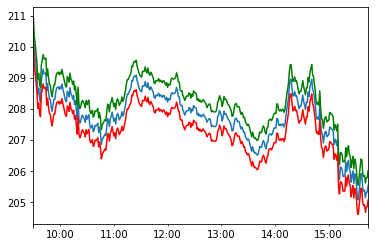

In [89]:
temp_.price.plot()
temp_.upper.plot(color='green')
temp_.lower.plot(color='red')